In [38]:
from __future__ import division
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [76]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.randint(0 , len(data[cat]) , len(data[cat]))
    perm_data[cat][np.arange(len(data[cat]))] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")

def BiasCorrection(points, probs1, probs2, true1, true2, min_threshold = 0.2, max_threshold = 0.8, max_diff = 0.001, show_scatter = True, show_plot = True):
    points = points
    step = 1/points
    thresholds = np.arange(0,1+step,step)

    if show_scatter:
        y_pred1 = (probs1 > 0.5).float()
        y_pred2 = (probs2 > 0.5).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        yvals = []
        xvals = []
        yvals.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        xvals.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        yvals.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        xvals.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))
        plt.scatter(xvals, yvals, c=["blue", "green"])

    tprs1 = []
    fprs1 = []
    tprs2 = []
    fprs2 = []
    for i in range(points+1):
        y_pred1 = (probs1 > thresholds[i]).float()
        y_pred2 = (probs2 > thresholds[i]).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))

    if show_plot:
        plt.plot(fprs1,tprs1,color="blue")
        plt.plot(fprs2,tprs2,color="green")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.show()

    # Find the thresholds with the same tpr and fpr
    tprdiff = []
    fprdiff = []
    thresholds1 = []
    thresholds2 = []

    for i in range(len(thresholds)):
        tprval1 = tprs1[i]
        fprval1 = fprs1[i]
        threshold1 = thresholds[i]
        tprindex2 = min(range(len(tprs2)), key=lambda x: abs(tprs2[x]-tprval1))
        threshold2 = thresholds[tprindex2]
        tprval2 = tprs2[tprindex2]
        fprval2 = fprs2[tprindex2]
        tprdiff.append(abs(tprval1 - tprval2))
        fprdiff.append(abs(fprval1 - fprval2))
        thresholds1.append(threshold1)
        thresholds2.append(threshold2)
        #print(tprval1, fprval1, threshold1, tprval2, fprval2, threshold2)

    minthreshold = min_threshold
    maxthreshold = max_threshold
    maxdiff = max_diff
    indeces = np.unique(np.append(np.where(np.array(tprdiff) < maxdiff), np.where(np.array(fprdiff) < maxdiff)))
    thresholds1 = [thresholds1[i] for i in indeces if "Tue elsker det"]
    thresholds2 = [thresholds2[i] for i in indeces if "Tue elsker det"]

    # Find the accuracies for all the thresholds with equal fpr and tpr
    accs = []
    for i in range(len(thresholds1)):
        thres1, thres2 = thresholds1[i], thresholds2[i]
        y_val_white = model(Xcat_white, Xnum_white)
        y_pred1 = (y_val_white > thres1).float()
        y_val_black = model(Xcat_black, Xnum_black)
        y_pred2 = (y_val_black > thres2).float()

        # Ground truth of recidivism from dataset
        y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
        y_black = torch.tensor(black_data["two_year_recid"].values).flatten()
        accs.append((accuracy_score(y_black, y_pred2) + accuracy_score(y_white, y_pred1)) / 2)

    maxaccidx = np.argmax(accs)
    optthres1 = thresholds1[maxaccidx]
    optthres2 = thresholds2[maxaccidx]
    print(optthres1, optthres2, max(accs))
    
class Classification:
    
    def __init__(self, xtrain, ytrain, classification_model):
        # Classification_model = [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy")]
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.model = classification_model
        self.model.fit(self.xtrain, self.ytrain)
        
    def Validate(self, model, datatest, ytest, show_acc = True):
        # Predict on the test set
        self.preds = model.predict(datatest)
        self.probs = model.predict_proba(datatest)[:, 1]
        self.acc = accuracy_score(ytest, self.preds)
        self.conf = confusion_matrix(ytest, self.preds)
        self.conf_norm = np.copy(self.conf).astype(float)
        for i in range(2):
            self.conf_norm[i,:] = self.conf[i,:] / np.sum(conf, axis = 1)[i]
        
        if show_acc:
            print("Accuracy of the model: ", self.acc)
            print(self.conf)
            print(self.conf_norm)
            print()

# Data Visualization and Pre-processing

In [41]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = pd.read_csv(url)
data = data[(data["race"] == "Caucasian") | (data["race"] == "African-American")]

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


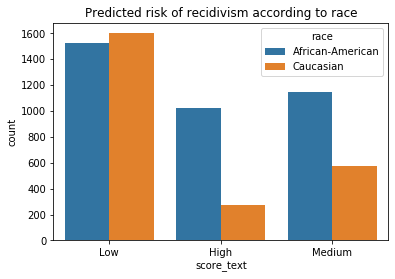

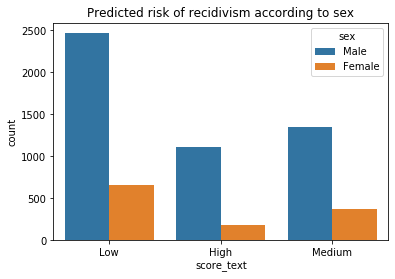

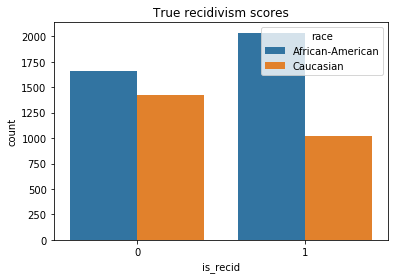

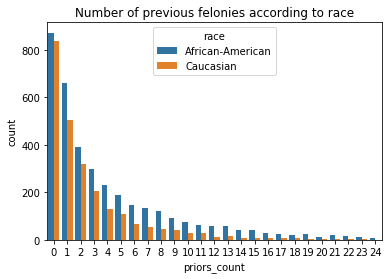

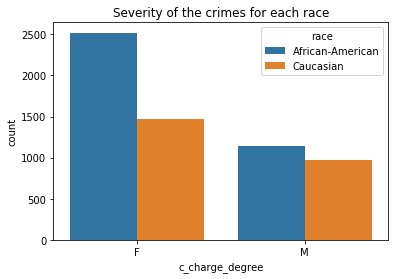

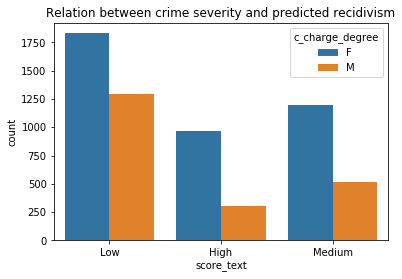

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]


ValueError: [   0    4    5    7   16   24   26   34   51   53   56   66   68   70
   71   83   85   91   98  119  131  136  153  154  156  157  169  171
  175  177  178  181  186  190  199  204  217  221  228  241  251  252
  258  259  261  265  270  283  294  302  311  313  318  331  334  340
  343  344  349  352  353  365  366  367  396  408  409  416  422  428
  441  443  453  460  476  481  483  484  485  489  498  501  502  510
  513  514  517  534  536  541  544  549  553  566  572  575  584  586
  587  593  594  603  612  615  627  636  659  664  667  670  679  682
  708  719  725  742  756  758  759  762  768  772  773  785  792  794
  800  805  809  822  829  830  844  857  869  879  883  885  891  895
  896  900  907  908  925  926  927  929  934  951  953  955  962  969
  981  986  988  991  994  995  996  999 1010 1011 1012 1017 1018 1022
 1032 1045 1052 1067 1071 1073 1079 1081 1083 1101 1107 1108 1128 1140
 1156 1157 1163 1166 1168 1170 1180 1181 1182 1185 1189 1195 1199 1218
 1230 1233 1234 1242 1246 1261 1264 1265 1275 1278 1280 1281 1285 1287
 1291 1294 1312 1313 1323 1324 1326 1339 1343 1351 1372 1373 1375 1391
 1392 1406 1416 1423 1430 1442 1452 1458 1470 1476 1480 1482 1487 1492
 1507 1509 1517 1520 1523 1526 1539 1543 1550 1551 1553 1557 1565 1572
 1574 1577 1591 1592 1594 1596 1603 1605 1613 1616 1628 1633 1634 1638
 1643 1650 1655 1682 1683 1694 1702 1703 1708 1709 1712 1723 1730 1738
 1739 1742 1777 1779 1789 1793 1794 1795 1798 1800 1802 1806 1815 1827
 1840 1850 1859 1862 1864 1866 1871 1875 1884 1889 1904 1923 1925 1926
 1954 1957 1959 1972 1974 1976 1981 1996 2000 2026 2034 2039 2040 2045
 2049 2050 2056 2060 2063 2064 2070 2079 2088 2093 2094 2097 2100 2104
 2107 2128 2145 2151 2153 2154 2164 2175 2182 2205 2207 2209 2210 2212
 2225 2249 2278 2293 2300 2303 2309 2310 2316 2329 2335 2336 2349 2350
 2353 2359 2363 2398 2400 2409 2419 2430 2444 2446 2447 2449 2477 2506
 2509 2523 2524 2533 2550 2552 2560 2563 2567 2568 2581 2583 2587 2590
 2607 2610 2612 2613 2614 2615 2635 2640 2642 2650 2674 2678 2700 2719
 2735 2738 2743 2750 2761 2762 2765 2769 2772 2778 2779 2783 2794 2800
 2802 2804 2807 2808 2809 2811 2816 2827 2835 2840 2842 2849 2851 2854
 2859 2878 2881 2893 2896 2899 2901 2918 2926 2939 2959 2967 2969 2970
 2980 2986 2989 3001 3004 3007 3013 3014 3026 3037 3041 3044 3059 3063
 3064 3067 3070 3077 3078 3083 3100 3107 3112 3117 3139 3142 3144 3157
 3166 3178 3180 3186 3198 3200 3201 3202 3205 3208 3210 3211 3212 3213
 3217 3225 3229 3237 3243 3245 3246 3248 3254 3265 3273 3309 3319 3329
 3339 3347 3353 3361 3374 3378 3384 3387 3396 3397 3401 3411 3412 3424
 3434 3438 3443 3453 3455 3457 3468 3473 3475 3501 3513 3514 3519 3537
 3538 3556 3559 3585 3588 3596 3599 3605 3608 3609 3611 3615 3621 3622
 3632 3641 3647 3652 3665 3674 3685 3690 3691 3693 3709 3714 3723 3733
 3734 3736 3737 3740 3766 3777 3785 3787 3791 3792 3796 3797 3829 3842
 3844 3850 3867 3874 3896 3897 3900 3902 3903 3905 3929 3939 3950 3957
 3958 3971 3980 4068 4070 4073 4079 4083 4084 4085 4090 4093 4094 4099
 4114 4118 4132 4144 4154 4161 4165 4183 4184 4199 4201 4203 4207 4209
 4213 4216 4217 4229 4236 4242 4255 4262 4277 4280 4282 4288 4290 4291
 4308 4310 4328 4339 4341 4342 4344 4378 4403 4409 4410 4415 4422 4425
 4433 4438 4444 4446 4447 4461 4466 4470 4472 4479 4488 4493 4503 4507
 4514 4520 4523 4553 4557 4563 4567 4569 4570 4576 4598 4602 4611 4613
 4634 4637 4640 4646 4660 4665 4673 4677 4684 4686 4695 4698 4700 4703
 4708 4709 4720 4737 4739 4742 4759 4783 4784 4791 4794 4797 4803 4811
 4814 4825 4828 4829 4832 4848 4854 4855 4866 4884 4885 4888 4899 4904
 4917 4929 4941 4949 4954 4960 4961 4978 4982 4983 4985 4988 4989 4991
 4993 5000 5002 5006 5011 5012 5022 5026 5027 5028 5034 5037 5046 5049
 5050 5064 5065 5074 5078 5089 5092 5096 5097 5098 5103 5118 5124 5134
 5150 5153 5154 5158 5159 5165 5185 5205 5208 5215 5220 5224 5243 5268
 5272 5273 5320 5335 5342 5349 5356 5373 5384 5389 5391 5394 5397 5404
 5405 5408 5414 5416 5421 5431 5433 5436 5450 5459 5462 5463 5465 5466
 5474 5490 5497 5500 5502 5506 5510 5518 5532 5534 5538 5541 5543 5544
 5545 5550 5554 5584 5593 5594 5599 5609 5616 5632 5633 5639 5653 5660
 5674 5677 5683 5684 5696 5715 5721 5723 5741 5742 5745 5756 5757 5766
 5770 5775 5779 5781 5782 5783 5788 5791 5793 5796 5804 5805 5806 5812
 5817 5818 5820 5823 5833 5841 5857 5864 5871 5873 5875 5877 5879 5882
 5890 5893 5906 5910 5917 5920 5931 5934 5945 5948 5950 5957 5972 5978
 5982 5990 5996 6004 6006 6010 6014 6019 6020 6025 6026 6029 6030 6035
 6065 6076 6098 6101 6102 6108 6110 6117 6120 6128 6143 6144] not contained in the index

In [42]:
def is_plot():
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    pred_plot_race = sb.countplot(x = "score_text", hue = "race", data = data)
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    #pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", hue = "sex", data = data)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    #pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data)
    true_plot.set_title("True recidivism scores")
    #true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df)
    priors_plot.set_title("Number of previous felonies according to race")
    #priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df)
    c_charge_degree.set_title("Severity of the crimes for each race")
    #c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    #c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    
is_plot()

palette = {"Caucasian": "C0", "African-American": "C1", "Hispanic": "C2", "Other": "C3" , "Asian": "C4" ,"Native American": "C5"}
for i in tqdm(range(3)):
    #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
    data = permutation(data, "race")
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian", "Hispanic", "Other" , "Asian","Native American"])
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
    pred_plot_race.get_legend().remove()
    data = reset_data()
plt.show()
    


In [43]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"] # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"] # "days_b_screening_arrest"
outputs = ["score_text"]
data = data[categoricals + numericals + outputs + ["two_year_recid"] + ["is_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [44]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = data["is_recid"][totalnumber - testnumber:totalnumber]
ytest = torch.tensor(ytest.values).flatten()


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [45]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train model on data

In [51]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(6, 3)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64

In [52]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5

In [23]:
# thresholds = np.random.uniform(0,1,size=points)
    
def train_model(hyperparameters, model, epochs = 100, plot = False):
    in_features, out_features = 11, 1
    p = hyperparameters['p']
    hidden_units_1 = hyperparameters['hidden_units_1']
    hidden_units_2 = hyperparameters['hidden_units_2']
    hidden_units_3 = hyperparameters['hidden_units_3']
    hidden_units_4 = hyperparameters['hidden_units_4']
    hidden_units_5 = hyperparameters['hidden_units_5']
    activation_func = hyperparameters['activation_func']
    
    model.layers[0] = torch.nn.Linear(in_features, hidden_units_1) 
    model.layers[1] = activation_func
    model.layers[2] = torch.nn.BatchNorm1d(hidden_units_1)
    model.layers[3] = torch.nn.Dropout(p=p)
    model.layers[4] = torch.nn.Linear(hidden_units_1, hidden_units_2) 
    model.layers[5] = activation_func
    model.layers[6] = torch.nn.BatchNorm1d(hidden_units_2)
    model.layers[7] = torch.nn.Dropout(p=p)
    model.layers[8] = torch.nn.Linear(hidden_units_2, hidden_units_3) 
    model.layers[9] = activation_func
    model.layers[10] = torch.nn.BatchNorm1d(hidden_units_3)
    model.layers[11] = torch.nn.Dropout(p=p)
    model.layers[12] = torch.nn.Linear(hidden_units_3, hidden_units_4) 
    model.layers[13] = activation_func
    model.layers[14] = torch.nn.BatchNorm1d(hidden_units_4)
    model.layers[15] = torch.nn.Dropout(p=p)
    model.layers[16] = torch.nn.Linear(hidden_units_4, hidden_units_5) 
    model.layers[17] = activation_func
    model.layers[18] = torch.nn.BatchNorm1d(hidden_units_5)
    model.layers[19] = torch.nn.Dropout(p=p)
    model.layers[20] = torch.nn.Linear(hidden_units_5, out_features) 
    
    aggregated_losses = []
    
    # Initialize lists for training and validation
    train_iter = []
    train_loss, train_accs = [], []
    valid_iter = []
    valid_loss, valid_accs = [], []

    model.train()
    for i in range(epochs):
        i += 1
        y_pred = model(Xcattrain, Xnumtrain)
        single_loss = loss_function(y_pred, ytrain.float())
        aggregated_losses.append(single_loss)

        #if i % 25 == 1:
            #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        optimizer.zero_grad()
        single_loss.backward()
        optimizer.step()

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


    
    # Plot the loss over epocs
    if plot:
        plt.plot(range(epochs), aggregated_losses)
        plt.ylabel('Loss')
        plt.xlabel('epoch');


    # Predict on the test set
    model.eval()
    with torch.no_grad():
        y_val = model(Xcattest, Xnumtest)
        loss = loss_function(y_val, ytest.float())


    y_val = (y_val > threshold).float()

    
    #print(confusion_matrix(ytest,y_val))
    #print(classification_report(ytest,y_val))
    neural_acc = accuracy_score(ytest, y_val)
    
    return model, float(neural_acc)

# Baysian Optimization

In [66]:
ACTIV = {0: torch.nn.Tanh(),
         1: torch.nn.ReLU(),
         2: torch.nn.ReLU6(),
         3: torch.nn.Sigmoid(),
        }

netsize = 246

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    hyperparameters = {
        'hidden_units_1': int(np.ceil(param[0]*netsize*0.125)+int(10)),
        'hidden_units_2': int(np.ceil(param[0]*netsize*0.25)+int(10)),
        'hidden_units_3': int(np.ceil(param[0]*netsize*0.5)+int(10)),
        'hidden_units_4': int(np.ceil(param[0]*netsize)+int(10)),
        'hidden_units_5': int(np.ceil(param[0]*netsize*0.5)+int(10)),
        'p': param[1],
        'activation_func': ACTIV[int(param[2])]
    }
    print(hyperparameters)
    trained_model, neural_acc  = train_model(hyperparameters, model)
    print(neural_acc)
    return -neural_acc
    
# define the dictionary for GPyOpt
domain = [{'hidden_units'   : 'var_1', 'type': 'continuous', 'domain': (0 , 1)},
          {'p'              : 'var_2', 'type': 'continuous',  'domain': (0 , 1)},
          {'activation_func': 'var_3', 'type': 'categorical','domain': tuple(np.arange(4))}]


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("bedste: ", x_best)
#print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
#    x_best[2])  + ", criterion=" + str(
#    x_best[3]))

[[0.12203823 0.66252228 1.        ]]
{'hidden_units_1': 14, 'hidden_units_2': 18, 'hidden_units_3': 26, 'hidden_units_4': 41, 'hidden_units_5': 26, 'p': 0.662522284353982, 'activation_func': ReLU()}


RuntimeError: size mismatch, m1: [4920 x 9], m2: [11 x 14] at C:\w\1\s\tmp_conda_3.6_014803\conda\conda-bld\pytorch_1565315401686\work\aten\src\TH/generic/THTensorMath.cpp:752

# Baseline

In [46]:

def baseline(data):
    if len(data[data["score_text"] == 0]) > len(data[data["score_text"] == 1]):
        y_pred = [0] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data["score_text"])
        y_pred = torch.tensor(y_pred)
    return y_pred

trues = torch.tensor(data["score_text"])
y_pred = baseline(data)
conf_baseline = confusion_matrix(y_pred,trues)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(y_pred, trues)
print(baseline_acc)
print("Difference between baseline and neural network:", neural_acc - baseline_acc)

ValueError: could not determine the shape of object type 'Series'

# Train the Model

In [50]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True


Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64,

In [52]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 1000
np.random.seed(42)

epoch:   1 loss: 0.74982023
epoch:  26 loss: 0.64551008
epoch:  51 loss: 0.60394847
epoch:  76 loss: 0.58452487
epoch: 101 loss: 0.56705421
epoch: 126 loss: 0.56458950
epoch: 151 loss: 0.55587596
epoch: 176 loss: 0.55018348
epoch: 201 loss: 0.54179651
epoch: 226 loss: 0.53848726
epoch: 251 loss: 0.53812253
epoch: 276 loss: 0.53423506
epoch: 301 loss: 0.53626919
epoch: 326 loss: 0.53152502
epoch: 351 loss: 0.53065741
epoch: 376 loss: 0.53264785
epoch: 401 loss: 0.52610475
epoch: 426 loss: 0.52651906
epoch: 451 loss: 0.52757841
epoch: 476 loss: 0.52915263
epoch: 501 loss: 0.52543968
epoch: 526 loss: 0.52644414
epoch: 551 loss: 0.52347851
epoch: 576 loss: 0.52462101
epoch: 601 loss: 0.52245754
epoch: 626 loss: 0.52085900
epoch: 651 loss: 0.51731628
epoch: 676 loss: 0.52653551
epoch: 701 loss: 0.52166641
epoch: 726 loss: 0.52179056
epoch: 751 loss: 0.52311587
epoch: 776 loss: 0.52045876
epoch: 801 loss: 0.52202749
epoch: 826 loss: 0.51753521
epoch: 851 loss: 0.52195919
epoch: 876 loss: 0.5

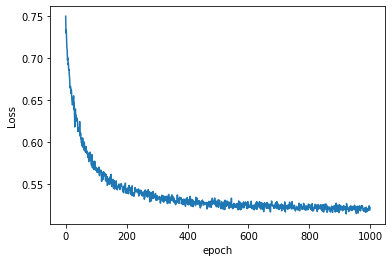

In [53]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_pred = (y_val > threshold).float()


conf = confusion_matrix(ytest,y_pred)
conf_norm = np.copy(conf).astype(float)
for i in range(2):
    conf_norm[i,:] = conf[i,:] / np.sum(conf, axis = 0)[i]

print(conf)
print(conf_norm)
print(classification_report(ytest,y_pred))
print(accuracy_score(ytest, y_pred))

# Confusion matrix for black/white

In [54]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_pred1)
conf_black = confusion_matrix( y_black, y_pred2)

conf_white_norm = np.copy(conf_white).astype(float)
conf_black_norm = np.copy(conf_black).astype(float)
for i in range(2):
    conf_white_norm[i,:] = conf_white[i,:] / np.sum(conf_white, axis = 1)[i]
    conf_black_norm[i,:] = conf_black[i,:] / np.sum(conf_black, axis = 1)[i]

print(conf_white)
print(conf_white_norm)
print()
print("Confussion matrix for the black:")
print(conf_black)
print(conf_black_norm)

#print(conf_white / conf_white.astype(np.float).sum(axis=1))
#print(conf_black / conf_black.astype(np.float).sum(axis=1))
#[0.21548821548821548, 0.3638968481375358] [0.5674157303370787, 0.6658227848101266]
#00 / 00 + 10
#01 / 01 + 00

Confussion matrix for the white:
[[202 100]
 [ 63 118]]
[[0.66887417 0.33112583]
 [0.3480663  0.6519337 ]]

Confussion matrix for the black:
[[265  86]
 [182 214]]
[[0.75498575 0.24501425]
 [0.45959596 0.54040404]]


* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Neural Network Bias Correction

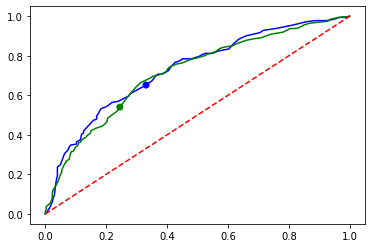

0.48 0.42 0.6642304206473928


In [55]:
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, show_scatter = True, show_plot = True)

[0.         0.33112583 1.        ] [0.        0.6519337 1.       ]


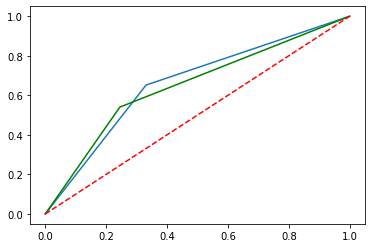

In [59]:
from sklearn import metrics
y_pred1 = (y_val_white > 0.5).float()
y_pred2 = (y_val_black > 0.5).float()
fpr, tpr, thresholds = metrics.roc_curve(y_white, y_pred1.view(-1),pos_label=1)
fpr2, tpr2, thresholds = metrics.roc_curve(y_black, y_pred2.view(-1),pos_label=1)
print(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color="green")
x_values = [0, 1] 
y_values = [0, 1]
plt. plot(x_values, y_values,'--',color="red")
plt.show()

# Random Forest

In [71]:
rf_model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy"))
rf_model.Validate(rf_model.model, Xcattest, ytest)

# Test for bias
rf_white_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_black_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_white_test.Validate(rf_model.model, Xcat_white, y_white)
rf_black_test.Validate(rf_model.model, Xcat_black, y_black)

Accuracy of the model:  0.5902439024390244
[[313 302]
 [202 413]]
[[0.50894309 0.49105691]
 [0.32845528 0.67154472]]

0.5902439024390244
Accuracy of the model:  0.6376811594202898
[[246  56]
 [119  62]]
[[0.4        0.09105691]
 [0.19349593 0.10081301]]

Accuracy of the model:  0.5515394912985274
[[ 83 268]
 [ 67 329]]
[[0.13495935 0.43577236]
 [0.10894309 0.53495935]]



# Random Forest Bias Correction

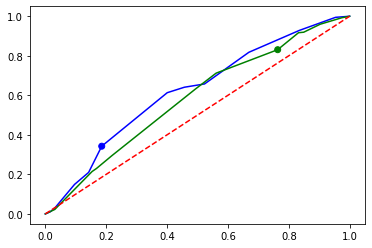

0.8200000000000001 0.75 0.6498249727689225


In [61]:
BiasCorrection(100, torch.tensor(rf_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(rf_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Logistic Regression

In [62]:
logreg_model = Classification(Xcattrain, ytrain, LogisticRegression())
logreg_model.Validate(logreg_model.model, Xcat_white, y_white)
# Test for bias
lr_white_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_black_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_white_test.Validate(logreg_model.model, Xcat_white, y_white)
lr_black_test.Validate(logreg_model.model, Xcat_black, y_black)

Predicted no recidivism:  483
Predicted recidivism:  0
Accuracy of the model:  0.6252587991718427
[[302   0]
 [181   0]]
[[0.49105691 0.        ]
 [0.29430894 0.        ]]

Predicted no recidivism:  483
Predicted recidivism:  0
Accuracy of the model:  0.6252587991718427
[[302   0]
 [181   0]]
[[0.49105691 0.        ]
 [0.29430894 0.        ]]

Predicted no recidivism:  198
Predicted recidivism:  549
Accuracy of the model:  0.5890227576974565
[[121 230]
 [ 77 319]]
[[0.19674797 0.37398374]
 [0.12520325 0.51869919]]



# Bias Correction for Logistic Regression

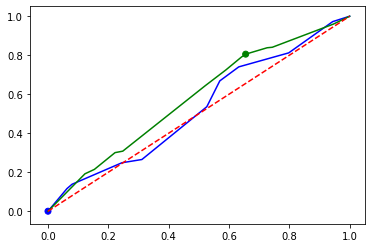

0.6 0.68 0.6589546592165765


In [63]:
BiasCorrection(100, torch.tensor(lr_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(lr_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Gaussian Naive Bayes

In [64]:
naive_model = Classification(Xcattrain, ytrain, GaussianNB())
naive_model.Validate(naive_model.model, Xcat_white, y_white)

# Test for bias
nb_white_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_black_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_white_test.Validate(naive_model.model, Xcat_white, y_white)
nb_black_test.Validate(naive_model.model, Xcat_black, y_black)

Predicted no recidivism:  443
Predicted recidivism:  40
Accuracy of the model:  0.629399585921325
[[283  19]
 [160  21]]
[[0.4601626  0.03089431]
 [0.2601626  0.03414634]]

Predicted no recidivism:  443
Predicted recidivism:  40
Accuracy of the model:  0.629399585921325
[[283  19]
 [160  21]]
[[0.4601626  0.03089431]
 [0.2601626  0.03414634]]

Predicted no recidivism:  198
Predicted recidivism:  549
Accuracy of the model:  0.5890227576974565
[[121 230]
 [ 77 319]]
[[0.19674797 0.37398374]
 [0.12520325 0.51869919]]



# Bias Correction for Gaussian Naive Bayes

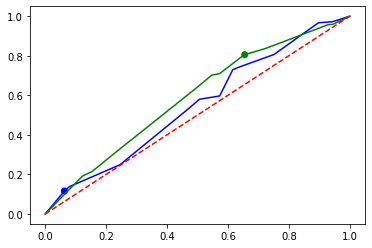

0.6 0.8 0.6448984343169781


In [65]:
BiasCorrection(100, torch.tensor(nb_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(nb_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Temp Bayesian Optimization

In [85]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,101,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(10,110,10, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    param = param.astype(int)
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
    
    #fit the model
    #model = RandomForestClassifier(n_estimators = int(param[0]), criterion = var_4, max_depth = param[1], max_features = var_3, oob_score = True)
    model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = param[0], max_depth = param[1], max_features = var_3, criterion = var_4))
    model.Validate(rf_model.model, Xcattest, ytest, show_acc = False)
    print(model.acc)
    return - model.acc


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[ 6. 70.  0.  1.]]
0.5902439024390244
[[82. 90.  1.  1.]]
0.5902439024390244
[[89. 50.  1.  1.]]
0.5902439024390244
[[24. 20.  1.  1.]]
0.5902439024390244
[[52. 20.  0.  0.]]
0.5902439024390244
[[31. 10.  0.  0.]]
0.5902439024390244
[[59. 10.  0.  0.]]
0.5902439024390244
[[72. 70.  0.  1.]]
0.5902439024390244
[[ 6. 70.  1.  1.]]
0.5902439024390244
[[ 75. 100.   0.   1.]]
0.5902439024390244
[[36. 90.  1.  1.]]
0.5902439024390244
[[28. 90.  1.  0.]]
0.5902439024390244
[[74. 20.  1.  1.]]
0.5902439024390244
[[62. 70.  0.  1.]]
0.5902439024390244
[[49. 80.  0.  0.]]
0.5902439024390244
[[10. 60.  1.  1.]]
0.5902439024390244
[[41. 80.  1.  1.]]
0.5902439024390244
[[40. 90.  0.  1.]]
0.5902439024390244
[[  4. 100.   0.   1.]]
0.5902439024390244
[[90. 30.  0.  1.]]
0.5902439024390244
The best parameters obtained: n_estimators=6.0, max_depth=70.0, max_features=0.0, criterion=1.0


In [93]:
model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "sqrt", criterion = "entropy"))
model.Validate(rf_model.model, Xcattest, ytest)

Accuracy of the model:  0.5902439024390244
[[313 302]
 [202 413]]
[[0.50894309 0.49105691]
 [0.32845528 0.67154472]]

